# Homework 2 CSCI 4364/6364 Machine Learning

##**Adventures in Linear Regression**
v.20230912a

**Due Date: 9/26/2023, 23:59 ET**

---

**Purpose:**
This homework will familiarize you with linear regression using the [Prostate Cancer dataset](https://hastie.su.domains/ElemStatLearn/data.html). First, you’ll work with the least squares. Then you’ll investigate regression using L2 (Ridge) and L1 (Lasso) regularization. Finally, you will implement an iterative version of L2 Regularization using gradient descent.

**Note**: Besides part 3, you should implement your solution with the fundamental equations we discussed in class and in Hastie, chapter 3. *Only in part 3, you should use Scikit-Learn*.



---
**Submission Instructions:**
This assignment will be done entirely in this Colaboratory notebook, and you will submit your notebook via GWU blackboard. Please embed your code in code blocks and add in comments into the text blocks.

**Important:** Please submit your assignment with outputs, by navigating to Edit >> Notebook Settings and ensuring *Omit code cell output when saving this notebook* is **NOT** selected.

---

**Grading on the notebook:**

Parts 1 - 4 of this notebook are worth 5% of the semester grade, where 3% is completion and full functionality, and 2% is based on comments and descriptions, and well-written and commented Python code, based on the coding standards. The notebook should be fully explained and work in its entirety when you submit it.

**Extra Credit!** Besides being a great learning experience about convex optimization, part 5 is **optional**, but worth up to 2% of the semester grade.

**Coding Standards:**
Throughout this course, we will use Google’s Python Style Guide (https://google.github.io/styleguide/pyguide.html) as the coding standard for homework and project submission. A big part of machine learning in industry is applying good programming practices.


**Name:** [please add your name here]

**GW ID:** [your GWU student ID]

In [1]:
#@title Imports
##########################################################
# Always include all imports at the first executable cell.
##########################################################
from abc import ABC, abstractmethod # Abstract Base Classes for Python
import pandas as pd # Pandas dataframe libaries
import numpy as np # Numpy numerical computation library
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn import metrics # Used to compute metrics, such as the Area Under the Curve (AUC)
import matplotlib.pyplot as plt # Plotting library.
from typing import Union, List, Tuple, Mapping # Common types for Python type definitions


# Data Preperation & Feature Analysis (Prostate Cancer)



In [2]:
#@title Load the Prostate Cancer dataset
_SEED = 1223
random_state = np.random.RandomState(_SEED)
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/prostate.csv')
# Randomize the rows
df = df.sample(frac =  1, random_state=random_state)

In [3]:
#@title Split into training and test set
# Following Hastie p.50, we create a training set of 67
split_index = 67
df_train = df.iloc[:split_index]
df_test = df.iloc[split_index:]

In [4]:
# let's look at the shape of the training and test sets
print(f"Training set shape: {df_train.shape}")
print(f"Test set shape: {df_test.shape}")

Training set shape: (67, 9)
Test set shape: (30, 9)


Since we have already loaded the data and split it into training and test sets, we can now begin to explore the data which is an indispensible part of every ML project. We will start by checking out some basic statistics of the data, such as the mean, standard deviation, and quartiles. We will also plot the data to see if we can find any trends.

In [5]:
df_train.describe()

lcavol    lweight        age       lbph        svi        lcp  \
count  67.000000  67.000000  67.000000  67.000000  67.000000  67.000000   
mean    1.281568   3.631081  63.492537   0.043592   0.208955  -0.305764   
std     1.225340   0.423991   7.558606   1.446755   0.409631   1.394618   
min    -1.347074   2.691243  41.000000  -1.386294   0.000000  -1.386294   
25%     0.460579   3.394507  60.000000  -1.386294   0.000000  -1.386294   
50%     1.308333   3.598681  64.000000  -0.051293   0.000000  -1.386294   
75%     2.293414   3.843729  68.000000   1.448936   0.000000   0.810930   
max     3.821004   4.780383  78.000000   2.326302   1.000000   2.583998   

         gleason      pgg45       lpsa  
count  67.000000  67.000000  67.000000  
mean    6.746269  24.253731   2.415862  
std     0.745558  28.528212   1.255188  
min     6.000000   0.000000  -0.430783  
25%     6.000000   0.000000   1.578766  
50%     7.000000  10.000000   2.591516  
75%     7.000000  45.000000   3.306402  
max     9.000000  95.000000   5.477509

Great, we can see some statistics of the different features we have. But, this will not tell us anything until we have an idea of what each feature represents. So let's take a look at the feature descriptions:

1. **lcavol**: Logarithm of cancer volume - Represents the natural logarithm of the volume of the cancer. A higher value indicates a larger tumor volume.

2. **lweight**: Logarithm of prostate weight - Represents the natural logarithm of the weight of the prostate. This feature helps in understanding the size of the prostate.

3. **age**: Age of the patient - Represents the age of the patient at the time of diagnosis. Age is a significant factor in prostate cancer risk.

4. **lbph**: Logarithm of benign prostatic hyperplasia amount - Represents the natural logarithm of the amount of benign prostatic hyperplasia (BPH). BPH is a noncancerous enlargement of the prostate gland.

5. **svi**: Seminal vesicle invasion - A binary feature indicating the presence (1) or absence (0) of seminal vesicle invasion. Seminal vesicle invasion is a sign of advanced disease.

6. **lcp**: Logarithm of capsular penetration - Represents the natural logarithm of the extent of capsular penetration. Capsular penetration indicates that cancer has grown through the prostate capsule.

7. **gleason**: Gleason score - A grading system used to determine the aggressiveness of prostate cancer. The score ranges from 2 to 10, with higher scores indicating more aggressive cancer.

8. **pgg45**: Percentage of Gleason scores 4 or 5 - Represents the percentage of the tumor that is composed of Gleason patterns 4 or 5. Higher percentages indicate more aggressive tumors.

9. **lpsa**: Logarithm of prostate-specific antigen - Represents the natural logarithm of the level of prostate-specific antigen (PSA) in the blood. Elevated PSA levels can indicate the presence of prostate cancer.


In this task, our goal is to develop several Regression Models from scratch and test the predictive capabilities of each model. The prediction target is the logarithm of the prostate-specific antigen (lpsa) which is a measure of the severity of the prostate cancer. We will use the mean squared error (MSE) as our loss function. The MSE is defined as:

$$ MSE = \frac{1}{n} \sum_{i=1}^{n} (Y_i - \hat{Y}_i)^2 $$

Where:
- \( n \) is the total number of observations in the dataset.
- \( Y_i \) is the actual value of the observation.
- \( \hat{Y}_i \) is the predicted value of the observation.


Now that we know what the task is and we have an idea of what the features represent, we can start analyzing the data. From the above description of the data, we can see that the features vary greatly in terms of their domain of values. For example, the feature **age** has a range of 41 to 79, while the feature **pgg45** has a range of 0 to 95. Also, some features exhibit high varience. Coupled with the fact that the amount of data we have is relatively small, this can cause problems for our models. This should certainly be kept in mind when we are developing the models and checking for correlations.

Let's confirm the distributions of the features using boxplots. Boxplots are a great way to visualize the distribution of the data. They show the median, quartiles, and outliers of the data. We will use the default quartile values for the boxplots which are 25% and 75%.

<AxesSubplot:>

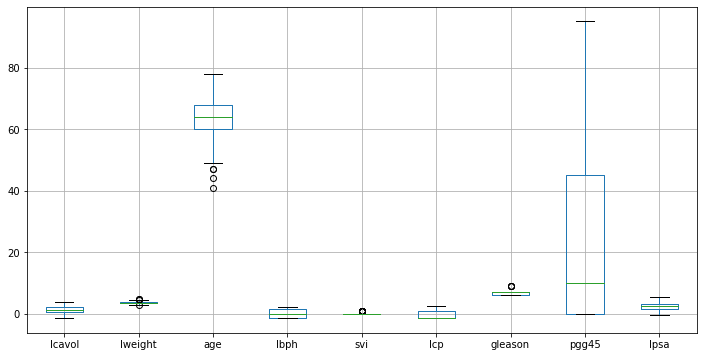

In [6]:
# Display the boxplot of the training set
df_train.boxplot(figsize=(12, 6))

The difference in value scales is quite apparent. We will test the models with the data as is, and then we will normalize the data and test the models again to see if there is any improvement. It is also importatn to check for correlations between the features. If two features are highly correlated, then we can remove one of them from the dataset. This will reduce the dimensionality of the data and will help the models perform better. We will use the Pearson correlation coefficient for this task.

<AxesSubplot:>

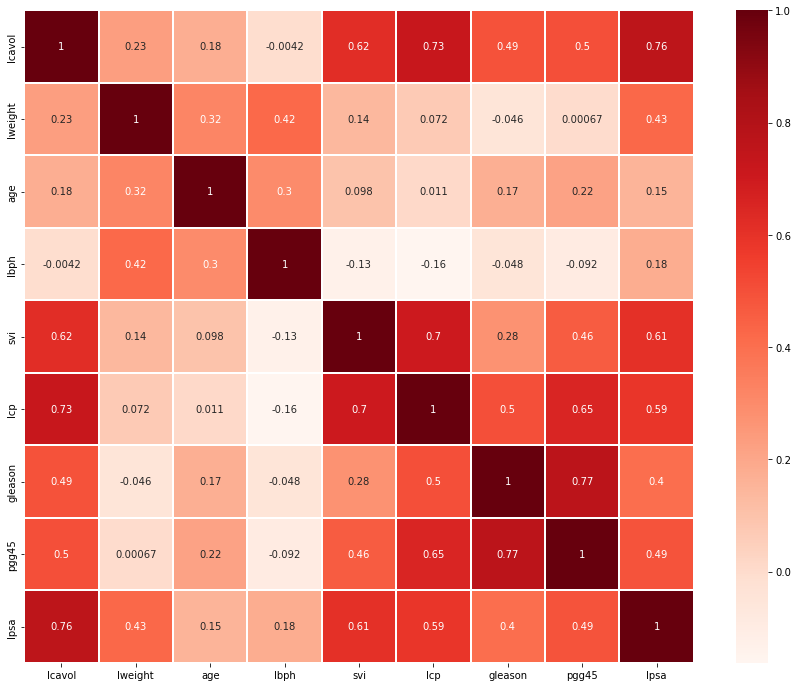

In [7]:
# Compute the Pearson correlation matrix
corr = df_train.corr()
# Plot the correlation heatmap
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corr, annot=True, cmap='Reds', 
            linewidths=0.2, ax=ax)

In [8]:
# Sorting the correlation matrix by the correlation to the lpsa column
corr_lpsa = corr['lpsa'].sort_values(ascending=False)
# Print the correlations to the lpsa column
print(f"Correlations to the lpsa column:\n{corr_lpsa}")

Correlations to the lpsa column:
lpsa       1.000000
lcavol     0.762191
svi        0.605025
lcp        0.590916
pgg45      0.491045
lweight    0.427177
gleason    0.400986
lbph       0.182307
age        0.152466
Name: lpsa, dtype: float64


There are some features that are highly correlated with the target variable, especially **lcavol** and **svi**. We'll see if our models judge them to be as important
We can also spot some features that are relatively strongly correlated with each other. The correlation levels are not so high that we should simply discard some of the variables, so we'll have to test and see

c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

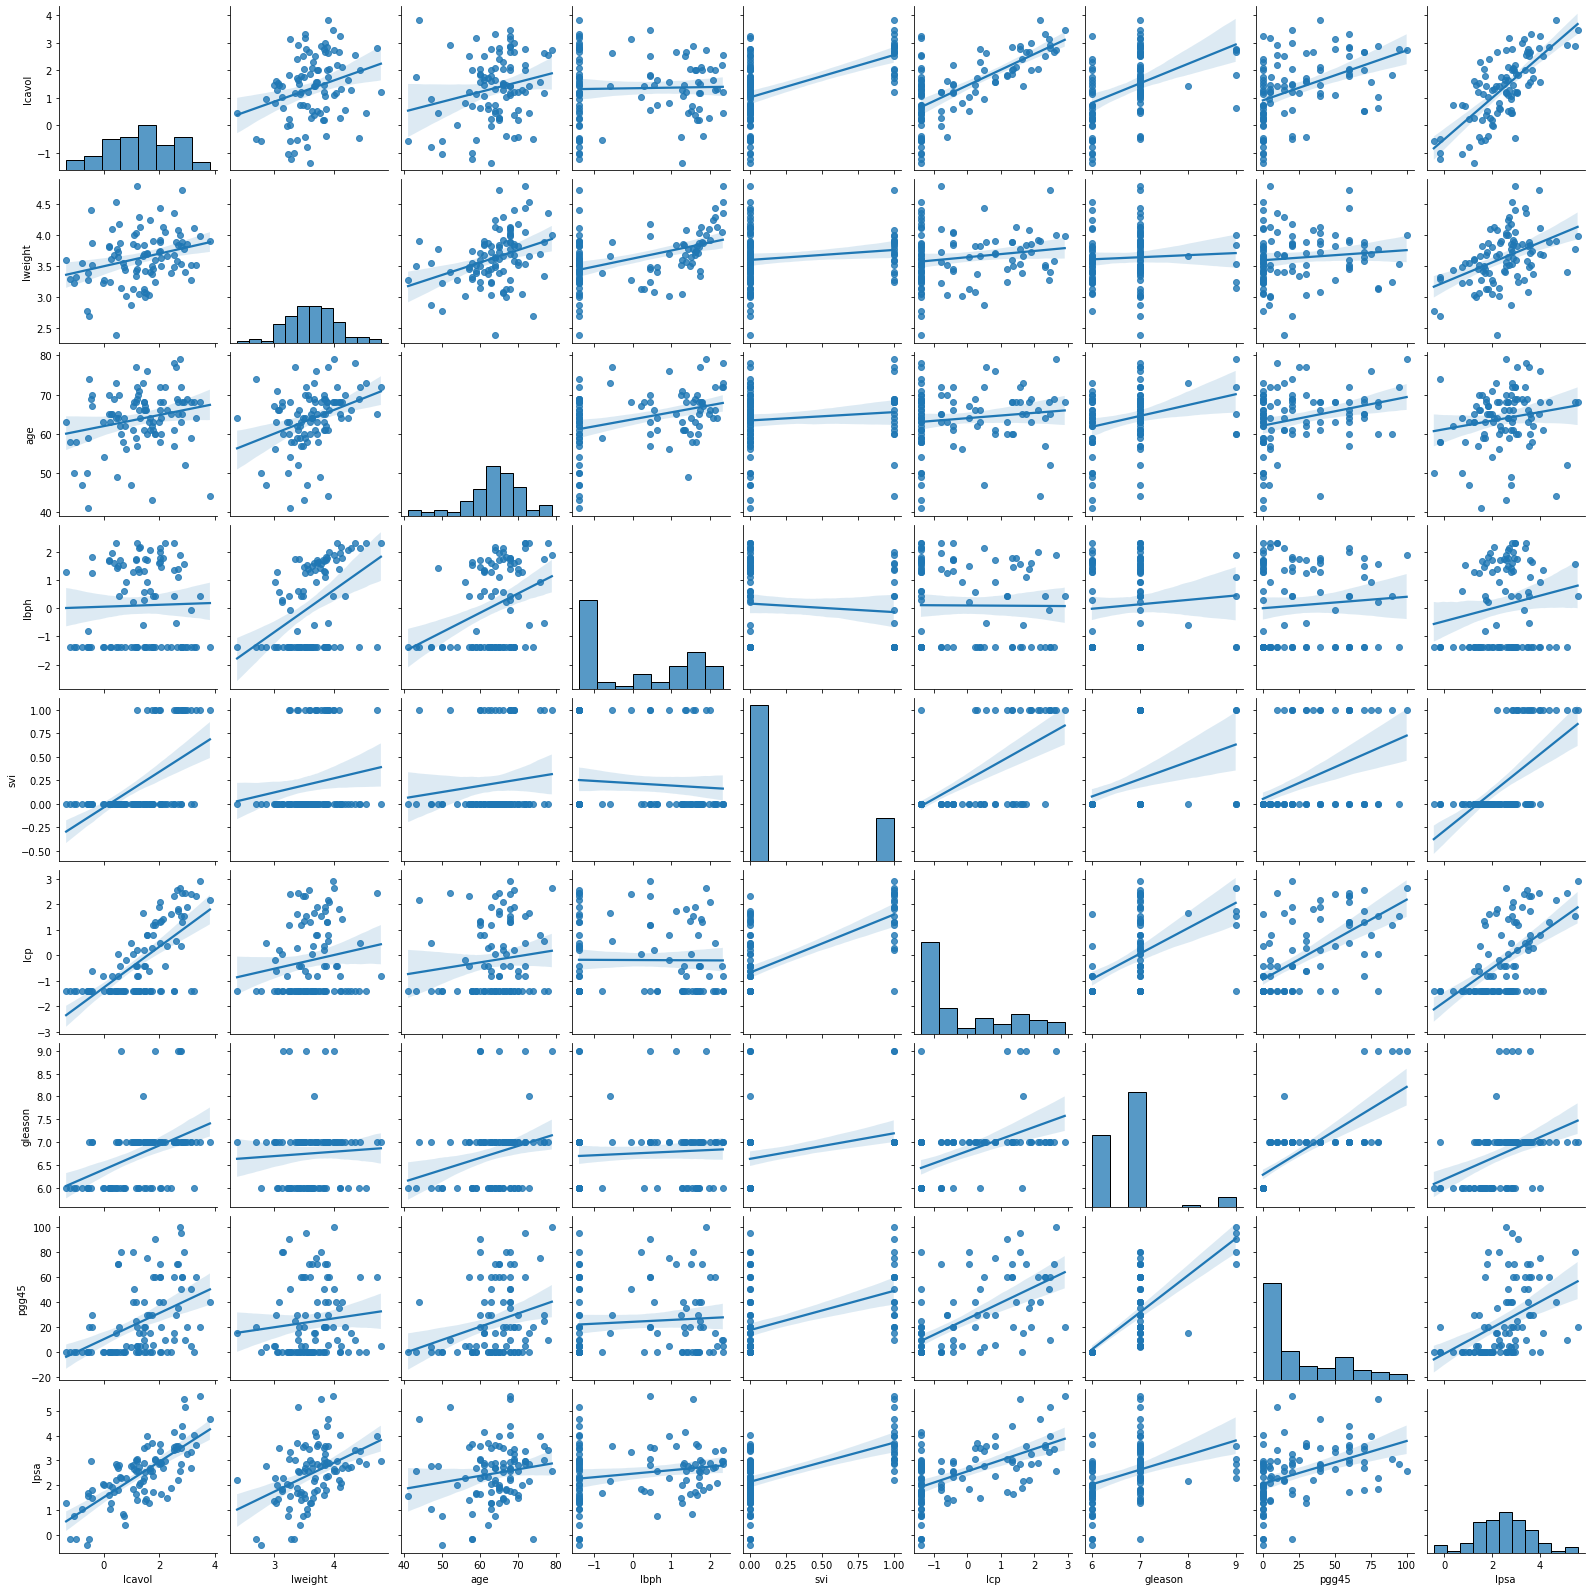

In [9]:
#@title Display pair plots
sns.pairplot(df, kind="reg")
plt.show()

In [10]:
#@title Split the labels and convert to numpy arrays
y_train = df_train['lpsa'].to_numpy()
X_train = df_train.copy().drop(columns = ['lpsa']).to_numpy()
y_test = df_test['lpsa'].to_numpy()
X_test = df_test.copy().drop(columns = ['lpsa']).to_numpy()

In [79]:
class BaseLearningAlgorithm(ABC):
    """Base class for a Supervised Learning Algorithm."""

    @abstractmethod
    def train(self, X_train: np.array, y_train: np.array) -> None:
        """Trains a model from labels y and examples X."""

    @abstractmethod
    def predict(self, X_test: np.array) -> np.array:
        """Predicts on an unlabeled sample, X."""

    @abstractmethod
    def initialize_with_params(self, params: Mapping[str, Union[int, float]]) -> None:
        """Initializes the algorithm with the given parameters."""

    @property
    @abstractmethod
    def name(self) -> str:
        """Returns the name of the algorithm."""
        
    def initialize_with_params(self, weights: np.array) -> None:
        """Initializes the algorithm with the given parameters."""
        self.weights = weights

In [12]:
def regression_report(y_test: np.ndarray, y_pred: np.ndarray, plot_results: bool=True) -> pd.DataFrame:
    """Reports and returns the regression metrics.
    Params:
      X_test: np.ndarray, shape (n_samples, n_features)
      y_test: np.ndarray, shape (n_samples,)
    Returns:
      results_df: pd.DataFrame, shape (1, 3)"""
    
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(y_test, y_pred)
    
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"R^2: {r2}")
    
    if plot_results:
      fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 6))
      # Plot the predictions vs. the true values
      ax1.scatter(y_test, y_pred, color='blue', alpha=0.5)
      # Plot the line y = x
      ax1.plot(y_test, y_test, 'r--' )
      ax1.set_xlabel("True values")
      ax1.set_ylabel("Predictions")
      ax1.set_title("Predictions vs. true values")
      
      # Plot the distribution of the residuals vs the distribution of the predictions
      sns.histplot(y_test - y_pred, bins=50, color='blue', ax=ax2)
      ax2.legend()
      ax2.set_title("Distribution of the Residuals")
      
    results_df = pd.DataFrame({'MSE': [mse], 'RMSE': [rmse], 'R^2': [r2]})
    return results_df

In [13]:
class Scaler(ABC):
    """Base class for a Scaler."""
    
    @abstractmethod
    def fit(self, 
            X: np.array,
            y: Union[np.array, None] = None
            ) -> None:
        """Fits the scaler to the data."""
    
    @abstractmethod
    def transform(self, 
            X: np.array,
            y: Union[np.array, None] = None
            ) -> np.array:
        """Transforms the data."""
        
    @abstractmethod
    def inverse_transform(self, 
            X: np.array,
            y: Union[np.array, None] = None
            ) -> np.array:
        """Inverse transforms the data."""

In [14]:
class StandardScaler(Scaler):
    """Apply standard scaling to the data."""
    
    def __init__(self):
        self.mean_X = None
        self.std_X = None
        
    def fit(self, 
            X: np.array,
            y: Union[np.array, None] = None
            ) -> None:
        """Fits the scaler to the data.
        Params:
        - X: np.array, shape (n_samples, n_features)
        - (optional) y: np.array, shape (n_samples,)
        Returns: None
        """
        self.mean_X = np.mean(X, axis=0)
        self.std_X = np.std(X, axis=0)
        
        if y is not None:
            self.mean_y = np.mean(y)
            self.std_y = np.std(y)
        
    def transform(self, 
            X: np.array,
            y: Union[np.array, None] = None
            ) -> Union[np.array, Tuple[np.array, np.array]]:
        """Transforms the data using the fitted scaler parameters.
        Params:
        - X: np.array, shape (n_samples, n_features)
        - (optional) y: np.array, shape (n_samples,)
        Returns:
        - X_scaled: np.array, shape (n_samples, n_features)
        - (optional) y_scaled: np.array, shape (n_samples,)
        """
        X_scaled = (X - self.mean_X) / self.std_X
        
        if y is not None:
            y_scaled = (y - self.mean_y) / self.std_y
            return X_scaled, y_scaled
        
        return X_scaled
    
    def inverse_transform(self, 
            X: Union[np.array, None] = None,
            y: Union[np.array, None] = None
            ) -> Union[np.array, Tuple[np.array, np.array]]:
        """Inverse transforms the data using the fitted scaler parameters.
        Params:
        - (optional) X: np.array, shape (n_samples, n_features)
        - (optional) y: np.array, shape (n_samples,)
        Returns:
        - X_scaled: np.array, shape (n_samples, n_features)
        - (optional) y_scaled: np.array, shape (n_samples,)
        """
        X_scaled = None 
        y_scaled = None
        
        if X is not None:
            X_scaled = X * self.std_X + self.mean_X
            
        if y is not None:
            y_scaled = y * self.std_y + self.mean_y
            
        if X_scaled is not None and y_scaled is not None:
            return X_scaled, y_scaled
        elif X_scaled is not None:
            return X_scaled
        elif y_scaled is not None:
            return y_scaled
        else:
            return None
        
        

In [15]:
class MinMaxScaler(Scaler):
    def __init__(self):
        self.min_X = None
        self.max_X = None
        
    def fit(self,
            X: np.array,
            y: Union[np.array, None] = None
            ) -> None:
        """Fits the scaler to the data.
        Params:
        - X: np.array, shape (n_samples, n_features)
        - (optional) y: np.array, shape (n_samples,)
        Returns: None
        """
        self.min_X = np.min(X, axis=0)
        self.max_X = np.max(X, axis=0)
        
        if y is not None:
            self.min_y = np.min(y)
            self.max_y = np.max(y)
            
    def transform(self, 
            X: np.array,
            y: Union[np.array, None] = None
            ) -> Union[np.array, Tuple[np.array, np.array]]:
        """Transforms the data using the fitted scaler parameters.
        Params:
        - X: np.array, shape (n_samples, n_features)
        - (optional) y: np.array, shape (n_samples,)
        Returns:
        - X_scaled: np.array, shape (n_samples, n_features)
        - (optional) y_scaled: np.array, shape (n_samples,)
        """
        X_scaled = (X - self.min_X) / (self.max_X - self.min_X)
        
        if y is not None:
            y_scaled = (y - self.min_y) / (self.max_y - self.min_y)
            return X_scaled, y_scaled
        
        return X_scaled
    
    def inverse_transform(self,
            X: Union[np.array, None] = None,
            y: Union[np.array, None] = None
            ) -> Union[np.array, Tuple[np.array, np.array]]:
        """Inverse transforms the data using the fitted scaler parameters.
        Params:
        - X: np.array, shape (n_samples, n_features)
        - (optional) y: np.array, shape (n_samples,)
        Returns:
        - X_scaled: np.array, shape (n_samples, n_features)
        - (optional) y_scaled: np.array, shape (n_samples,)
        """
        X_scaled = None 
        y_scaled = None
        
        if X is not None:
            X_scaled = X * (self.max_X - self.min_X) + self.min_X
            
        if y is not None:
            y_scaled = y * (self.max_y - self.min_y) + self.min_y
            
        if X_scaled is not None and y_scaled is not None:
            return X_scaled, y_scaled
        elif X_scaled is not None:
            return X_scaled
        elif y_scaled is not None:
            return y_scaled
        else:
            return None            
        

In [16]:
class LogTransformScaler(Scaler):
    def __init__(self):
        self.min_X = None
        self.max_X = None

    def fit(self, X: np.array, y: Union[np.array, None] = None) -> None:
        """Fits the scaler to the data.
        Params:
        - X: np.array, shape (n_samples, n_features)
        - (optional) y: np.array, shape (n_samples,)
        Returns: None
        """
        self.min_X = np.min(X, axis=0)

        if y is not None:
            self.min_y = np.min(y)

    def transform(
        self, X: np.array, y: Union[np.array, None] = None
    ) -> Union[np.array, Tuple[np.array, np.array]]:
        """Transforms the data using the fitted scaler parameters.
        Params:
        - X: np.array, shape (n_samples, n_features)
        - (optional) y: np.array, shape (n_samples,)
        Returns:
        - X_scaled: np.array, shape (n_samples, n_features)
        - (optional) y_scaled: np.array, shape (n_samples,)
        """
        X_scaled = np.log(X + np.abs(self.min_X) + 1)

        if y is not None:
            y_scaled = np.log(y + np.abs(self.min_y) + 1)
            return X_scaled, y_scaled

        return X_scaled

    def inverse_transform(
        self, X: Union[np.array, None] = None, y: Union[np.array, None] = None
    ) -> Union[np.array, Tuple[np.array, np.array]]:
        """Inverse transforms the data using the fitted scaler parameters.
        Params:
        - X: np.array, shape (n_samples, n_features)
        - (optional) y: np.array, shape (n_samples,)
        Returns:
        - X_scaled: np.array, shape (n_samples, n_features)
        - (optional) y_scaled: np.array, shape (n_samples,)
        """
        X_scaled = None
        y_scaled = None

        if X is not None:
            X_scaled = np.exp(X) - np.abs(self.min_X) - 1

        if y is not None:
            y_scaled = np.exp(y) - np.abs(self.min_y) - 1

        if X_scaled is not None and y_scaled is not None:
            return X_scaled, y_scaled
        elif X_scaled is not None:
            return X_scaled
        elif y_scaled is not None:
            return y_scaled
        else:
            return None

In [17]:
# def standardize(X: np.array, 
#                 mean: Union[np.array, None] = None, 
#                 std: Union[np.array, None] = None 
#                 ) -> np.array:
#   """Standardizes the columns of the matrix X. If mean and std are not None,
#     then these values are used to standardize the matrix X. Otherwise, the
#     mean and std are computed from the matrix X.
#   """
  
#   if not mean or not std:
#     mean = np.mean(X, axis=0)
#     std = np.std(X, axis=0)
#   elif mean.shape != X.shape[1] or std.shape != X.shape[1]:
#     raise ValueError("The mean and std must have the same shape as the number of columns in X.")
#   elif not mean and std or mean and not std:
#     raise ValueError("The mean and std must be both None or both must be specified.")
  
#   return (X - mean) / std, mean, std

# 1. Linear Regression with Least Squares
Implement a class called `BasicLeastSquaresRegression` that extends `BaseLearningAlgorithm` with “vanilla” least squares regression described in Hastie 3.2. Compute the $\boldsymbol{\beta}$ coefficient vector and solve for $\hat{y} $ and compute the performance result as the mean squared error on the test set. Use only numpy for your solution.





**Questions:**

**1.1** What MSE loss score do you get with Least Squares?

**1.2** What variables carry the greatest influence (i.e., are the most important) in the least squares regression?

**1.3** Does normalizing the data improve performance (lower MSE loss)? If so, why?


In [81]:
class BasicLeastSquaresRegression(BaseLearningAlgorithm):
    """A basic least squares regression model.
    This model is not regularized.
    """

    def __init__(self):
        """Initializes the model."""
        self._model = None

    def train(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        """Trains the model."""
        # Add a column of ones to the training data
        # this is to account for the bias term
        # see Hastie p. 45
        X_train = np.c_[X_train, np.ones(X_train.shape[0])]
        # Compute the least squares solution using eq. 3.6
        self._weights = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Predicts on an unlabeled sample, X."""
        # Add a column of ones to the test data
        X_test = np.c_[X_test, np.ones(X_test.shape[0])]
        # Return the predictions
        return X_test @ self._weights

    @property
    def name(self) -> str:
        """Returns the name of the algorithm."""
        return "Least Squares Regression"

Mean Squared Error: 0.5561806405313257
Root Mean Squared Error: 0.7457751943657859
R^2: 0.2773118726338625


c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


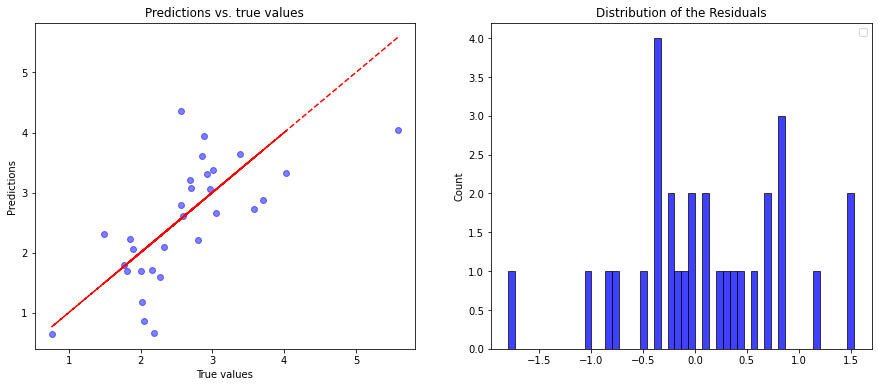

In [19]:
LSR = BasicLeastSquaresRegression()
LSR.train(X_train, y_train)
y_pred_lsr = LSR.predict(X_test)
reg_res_og = regression_report(y_test, y_pred_lsr)


Now, let's examine the importance of the features in the model. We will use the absolute value of the coefficients as a measure of importance. The higher the absolute value of the coefficient, the more important the feature is.

In [69]:
def display_feature_ranking(df_train: pd.DataFrame, weights: np.ndarray) -> None:
    """Displays the feature ranking."""
    sorted_features = np.argsort(weights)[::-1]

    fig, ax = plt.subplots(figsize=(12, 6))
    plot = sns.barplot(
        x=weights[sorted_features],
        y=df_train.columns[sorted_features],
        ax=ax,
        palette="plasma",
    )

    # Annotate the bars
    for p in plot.patches:
        ax.annotate(
            "%.4f" % p.get_width(),
            xy=(p.get_width(), p.get_y() + p.get_height() / 2),
            xytext=(5, 0),
            textcoords="offset points",
            ha="left",
            va="center",
        )

c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


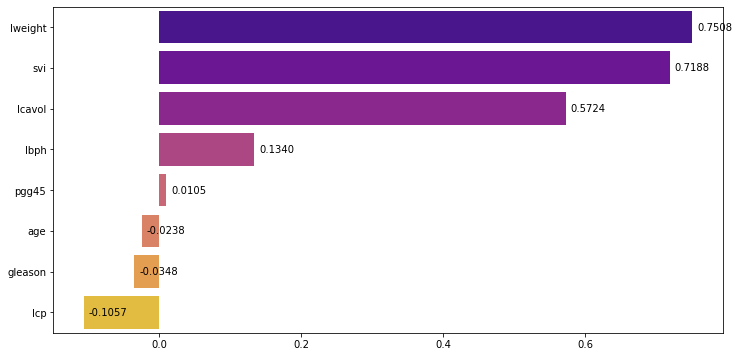

In [21]:
# Display the feature ranking
display_feature_ranking(df_train, LSR._weights[:-1])

We can see that the MSE loss is quite high and our R2 score is quite low. Model performance does not seem to be reliable at all. One of the nuances we spotted early on was the difference in value scales of the features. Let's see if normalizing the data will improve performance. We'll try standard, min-max, and log normalization.

c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mean Squared Error: 0.5561806405313204
Root Mean Squared Error: 0.7457751943657823
R^2: 0.27731187263386925


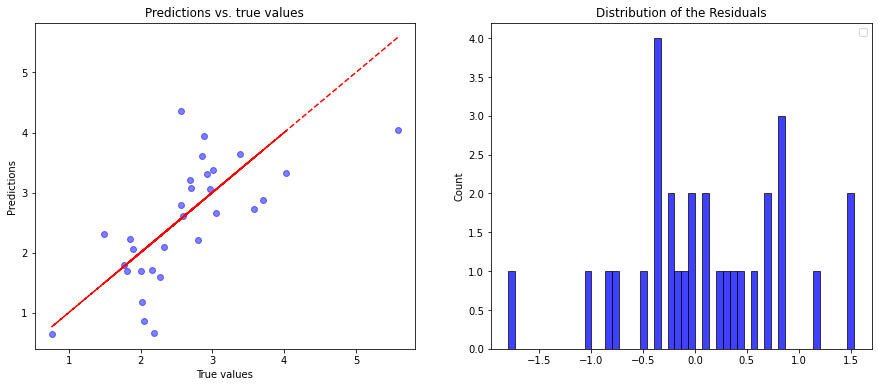

In [22]:
# Normalize the data using the StandardScaler
std_scaler = StandardScaler()
std_scaler.fit(X_train, y_train)
X_train_std, y_train_std = std_scaler.transform(X_train, y_train)
X_test_std = std_scaler.transform(X_test)

# Train the model on the standardized data
LSR_std = BasicLeastSquaresRegression()
LSR_std.train(X_train_std, y_train_std)
y_pred_lsr_std = LSR_std.predict(X_test_std)
y_pred_lsr_std = std_scaler.inverse_transform(y=y_pred_lsr_std)

reg_res_std = regression_report(y_test, y_pred_lsr_std)

c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


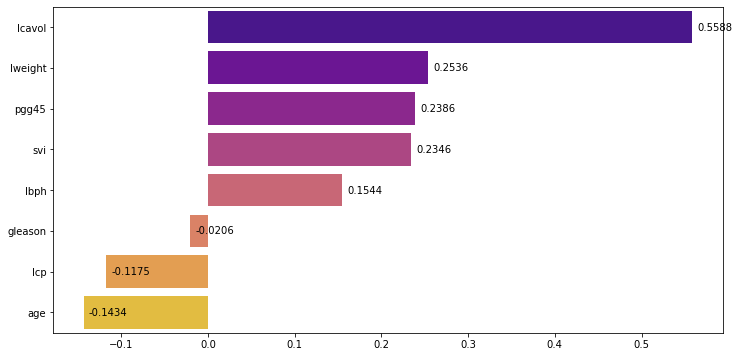

In [23]:
# Display the feature ranking
display_feature_ranking(df_train, LSR_std._weights[:-1])

c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mean Squared Error: 0.556180640531318
Root Mean Squared Error: 0.7457751943657807
R^2: 0.27731187263387247


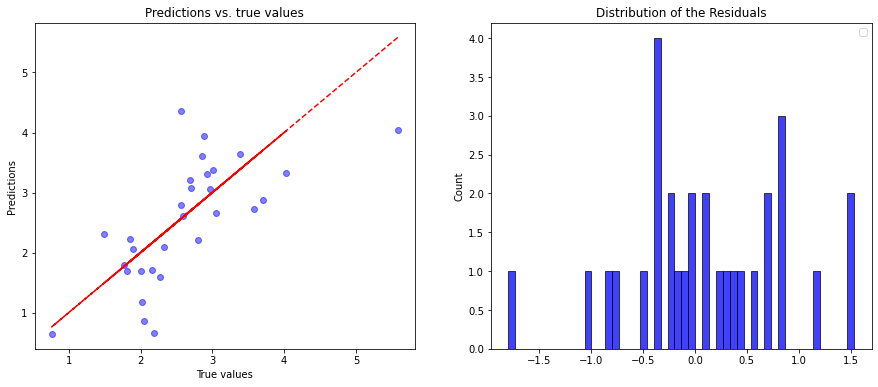

In [24]:
# Normalize the data using the MinMaxScaler
mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train, y_train)
X_train_mm, y_train_mm = mm_scaler.transform(X_train, y_train)
X_test_mm = mm_scaler.transform(X_test)

# Train the model on the normalized data
LSR_mm = BasicLeastSquaresRegression()
LSR_mm.train(X_train_mm, y_train_mm)
y_pred_lsr_mm = LSR_mm.predict(X_test_mm)
y_pred_lsr_mm = mm_scaler.inverse_transform(y=y_pred_lsr_mm)

reg_res_mm = regression_report(y_test, y_pred_lsr_mm)

c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


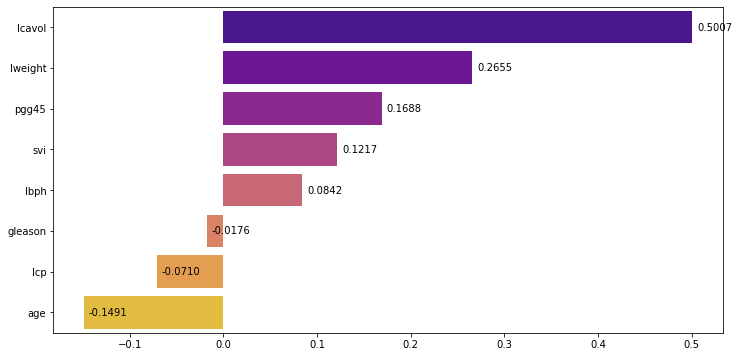

In [25]:
# Display the feature ranking
display_feature_ranking(df_train, LSR_mm._weights[:-1])

c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mean Squared Error: 0.640561580795773
Root Mean Squared Error: 0.8003509110357612
R^2: 0.16766925068490113


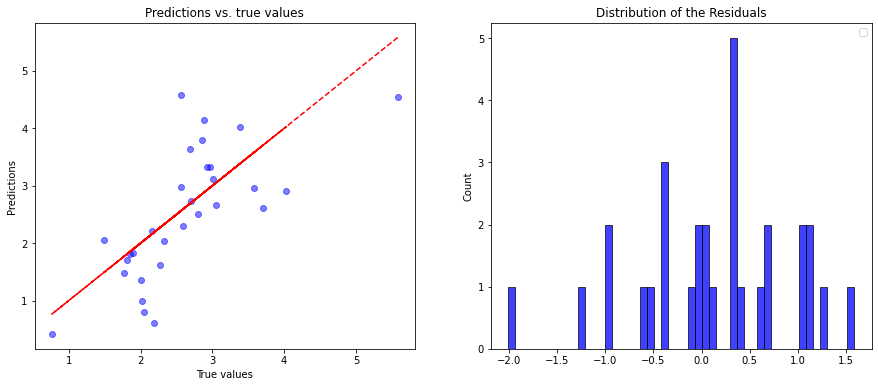

In [26]:
# Normalize the data using the LogTransformScaler
log_scaler = LogTransformScaler()
log_scaler.fit(X_train, y_train)
X_train_log, y_train_log = log_scaler.transform(X_train, y_train)
X_test_log, y_test_log = log_scaler.transform(X_test, y_test)

# Train the model on the normalized data
LSR_log = BasicLeastSquaresRegression()
LSR_log.train(X_train_log, y_train_log)
y_pred_lsr_log = LSR_log.predict(X_test_log)
y_pred_lsr_log = log_scaler.inverse_transform(y=y_pred_lsr_log)

reg_res_log = regression_report(y_test, y_pred_lsr_log)

c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


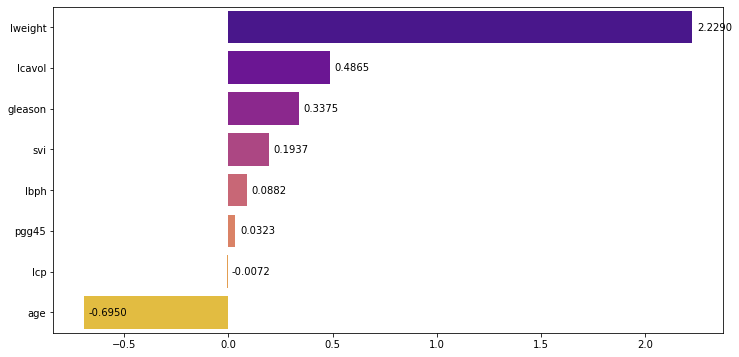

In [27]:
# Display the feature ranking
display_feature_ranking(df_train, LSR_log._weights[:-1])

# 2. Linear Regression with L2 Regularization (Ridge)

Using the closed-form solution to Ridge Regression, implement a class called `RidgeRegression` that extends `BaseLearningAlgorithm` based on Hastie 3.41. Iterate through the regression penalty term, $\lambda$, and plot (a) MSE loss as a function of $\lambda$, and (b) each coefficient weight as a function of $\lambda$. Use only numpy and matplotlib for your solution.


In [82]:
class RidgeRegression(BaseLearningAlgorithm):
    """A Ridge Regression model implementing eq. 3.44."""
    
    def __init__(self, lambda_R: float):
        """Initializes the model."""
        self._model = None
        self.lambda_R = lambda_R
    
    def train(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        """Trains the model."""
        # Add a column of ones to the training data
        # this is to account for the bias term
        # see Hastie p. 45
        X_train = np.c_[X_train, np.ones(X_train.shape[0])]
        # Compute the least squares solution using eq. 3.44
        self._weights = np.linalg.inv(X_train.T @ X_train + self.lambda_R * np.eye(X_train.shape[1])) @ X_train.T @ y_train
    
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Predicts on an unlabeled sample, X."""
        # Add a column of ones to the test data
        X_test = np.c_[X_test, np.ones(X_test.shape[0])]
        # Return the predictions
        return X_test @ self._weights
        
    @property
    def name(self) -> str:
        """Returns the name of the algorithm."""
        return "Ridge Regression"

Let's test this implementation by comparing the results of RidgeRegression when $\lambda = 0$ with the results of BasicLeastSquaresRegression. They should be the same.

c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mean Squared Error: 0.5561806405313257
Root Mean Squared Error: 0.7457751943657859
R^2: 0.2773118726338625


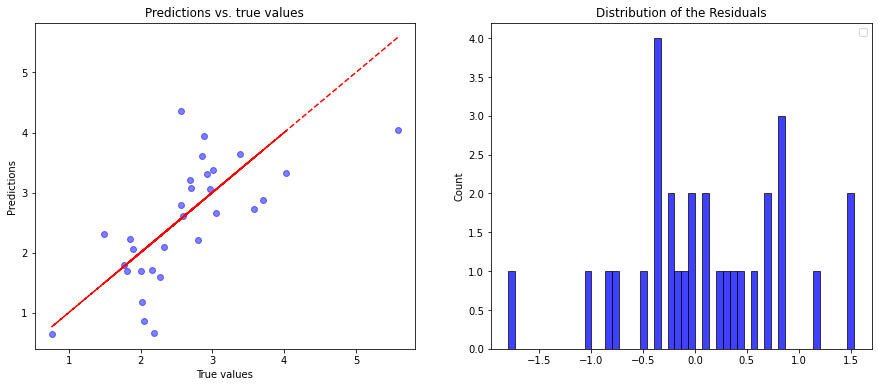

In [29]:
ridge_regression_model = RidgeRegression(lambda_R=0)
ridge_regression_model.train(X_train, y_train)

y_pred_ridge = ridge_regression_model.predict(X_test)
reg_res_ridge = regression_report(y_test, y_pred_ridge)

In [30]:
# let's see if the results are the same between BasicLeastSquaresRegression and RidgeRegression when lambda_R = 0
print(f"Are the results the same? {np.allclose(LSR._weights, ridge_regression_model._weights)}")

Are the results the same? True


Judging by the results, the two models seem to be equal. This is expected since the penalty term is zero. Let's see what happens when we increase the penalty term.

In [43]:
lambda_R_range = np.linspace(0, 150, 10000).tolist()

# Setting up a dataframe where we'll store the results and the weights
metrics_to_track = (
    ["lambda", "mse", "rmse", "r2"]
    + [f"w_{feature}" for feature in df_train.columns if feature != "lpsa"]
    + ["bias"]
)
print(f"Metrics to track: {metrics_to_track}")
results = np.zeros((len(lambda_R_range), len(metrics_to_track)))

std_scaler = StandardScaler()
std_scaler.fit(X_train, y_train)
X_train_std, y_train_std = std_scaler.transform(X_train, y_train)
X_test_std = std_scaler.transform(X_test)

for i, lambda_R in enumerate(lambda_R_range):
    print(f">>> Model {i}/{len(lambda_R_range)}. Lambda_R: {lambda_R}")

    ridge_regression_model = RidgeRegression(lambda_R=lambda_R)
    ridge_regression_model.train(X_train_std, y_train_std)
    y_pred_ridge = ridge_regression_model.predict(X_test_std)
    y_pred_ridge = std_scaler.inverse_transform(y=y_pred_ridge)

    ridge_reg_results = regression_report(y_test, y_pred_ridge, plot_results=False)
    rr_test_mse = ridge_reg_results["MSE"][0]
    rr_test_rmse = ridge_reg_results["RMSE"][0]
    rr_test_r2 = ridge_reg_results["R^2"][0]

    weights = ridge_regression_model._weights.tolist()
    # record the results
    results[i] = [lambda_R, rr_test_mse, rr_test_rmse, rr_test_r2] + weights

Metrics to track: ['lambda', 'mse', 'rmse', 'r2', 'w_lcavol', 'w_lweight', 'w_age', 'w_lbph', 'w_svi', 'w_lcp', 'w_gleason', 'w_pgg45', 'bias']
>>> Model 0/10000. Lambda_R: 0.0
Mean Squared Error: 0.5561806405313204
Root Mean Squared Error: 0.7457751943657823
R^2: 0.27731187263386925
>>> Model 1/10000. Lambda_R: 0.015001500150015001
Mean Squared Error: 0.5560690446241787
Root Mean Squared Error: 0.7457003718814808
R^2: 0.2774568777478139
>>> Model 2/10000. Lambda_R: 0.030003000300030003
Mean Squared Error: 0.55595813943494
Root Mean Squared Error: 0.7456260050688549
R^2: 0.2776009853590561
>>> Model 3/10000. Lambda_R: 0.045004500450045004
Mean Squared Error: 0.5558479199209603
Root Mean Squared Error: 0.745552090682442
R^2: 0.2777442020198897
>>> Model 4/10000. Lambda_R: 0.060006000600060005
Mean Squared Error: 0.5557383810809287
Root Mean Squared Error: 0.7454786255023873
R^2: 0.2778865342289012
>>> Model 5/10000. Lambda_R: 0.075007500750075
Mean Squared Error: 0.5556295179544795
Root

In [44]:
# Let's sort the results by the MSE and R2
results_df = pd.DataFrame(results, columns=metrics_to_track)
results_df.sort_values(by=['mse', 'r2'], ascending=[True, False], inplace=False).head(10)

lambda       mse      rmse        r2  w_lcavol  w_lweight     w_age  \
8074  121.122112  0.481537  0.693929  0.374302  0.181261   0.118970  0.007798   
8073  121.107111  0.481537  0.693929  0.374302  0.181272   0.118977  0.007796   
8075  121.137114  0.481537  0.693929  0.374302  0.181250   0.118962  0.007800   
8072  121.092109  0.481537  0.693929  0.374302  0.181283   0.118985  0.007794   
8076  121.152115  0.481537  0.693929  0.374302  0.181238   0.118954  0.007802   
8071  121.077108  0.481537  0.693929  0.374302  0.181294   0.118993  0.007792   
8077  121.167117  0.481537  0.693929  0.374302  0.181227   0.118946  0.007804   
8070  121.062106  0.481537  0.693929  0.374302  0.181305   0.119001  0.007790   
8078  121.182118  0.481537  0.693929  0.374302  0.181216   0.118939  0.007806   
8069  121.047105  0.481537  0.693929  0.374302  0.181316   0.119008  0.007788   

        w_lbph     w_svi     w_lcp  w_gleason   w_pgg45          bias  
8074  0.062284  0.126980  0.102290   0.060024  0.082571 -3.426079e-17  
8073  0.062289  0.126987  0.102293   0.060026  0.082574 -4.510281e-17  
8075  0.062279  0.126974  0.102287   0.060023  0.082569 -4.900594e-17  
8072  0.062293  0.126993  0.102296   0.060027  0.082577 -4.597017e-17  
8076  0.062275  0.126968  0.102284   0.060022  0.082566 -4.206704e-17  
8071  0.062298  0.126999  0.102299   0.060028  0.082580 -4.640385e-17  
8077  0.062270  0.126961  0.102282   0.060021  0.082563 -5.117434e-17  
8070  0.062302  0.127005  0.102302   0.060029  0.082583 -5.724587e-17  
8078  0.062265  0.126955  0.102279   0.060019  0.082560 -5.854692e-17  
8069  0.062307  0.127012  0.102305   0.060031  0.082586 -7.025630e-17

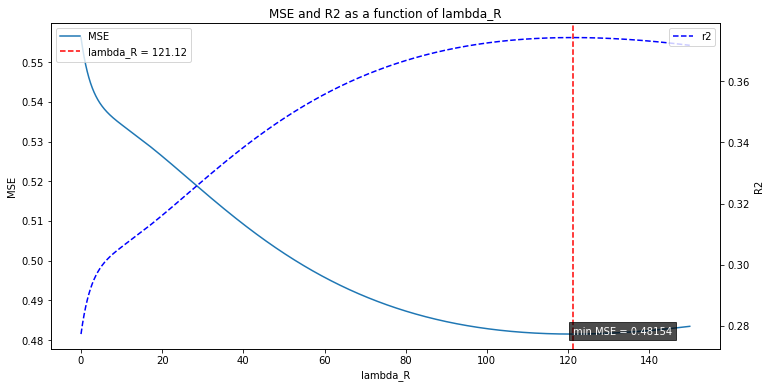

In [45]:
# let's pot the MSE and R2 as a function of lambda_R
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(results_df["lambda"].values, results_df["mse"].values, label="MSE")

# Add a vertical line at the minimum MSE
min_mse = results_df["mse"].min()
min_mse_lambda = results_df[results_df["mse"] == min_mse]["lambda"].values[0]
ax.axvline(
    min_mse_lambda,
    color="red",
    linestyle="--",
    label=f"lambda_R = {min_mse_lambda:.2f}",
)
# Add text annotation for the minimum MSE with a black background and white text
ax.text(
    min_mse_lambda,
    min_mse,
    f"min MSE = {min_mse:.5f}",
    bbox=dict(facecolor="black", alpha=0.7),
    color="white",
)


# Create a twin Axes sharing the xaxis for the r2
ax2 = ax.twinx()
ax2.plot(results_df["lambda"].values, results_df["r2"].values, "b--", label="r2")
ax.set_xlabel("lambda_R")
ax.set_ylabel("MSE")
ax2.set_ylabel("R2")
ax.set_title("MSE and R2 as a function of lambda_R")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")

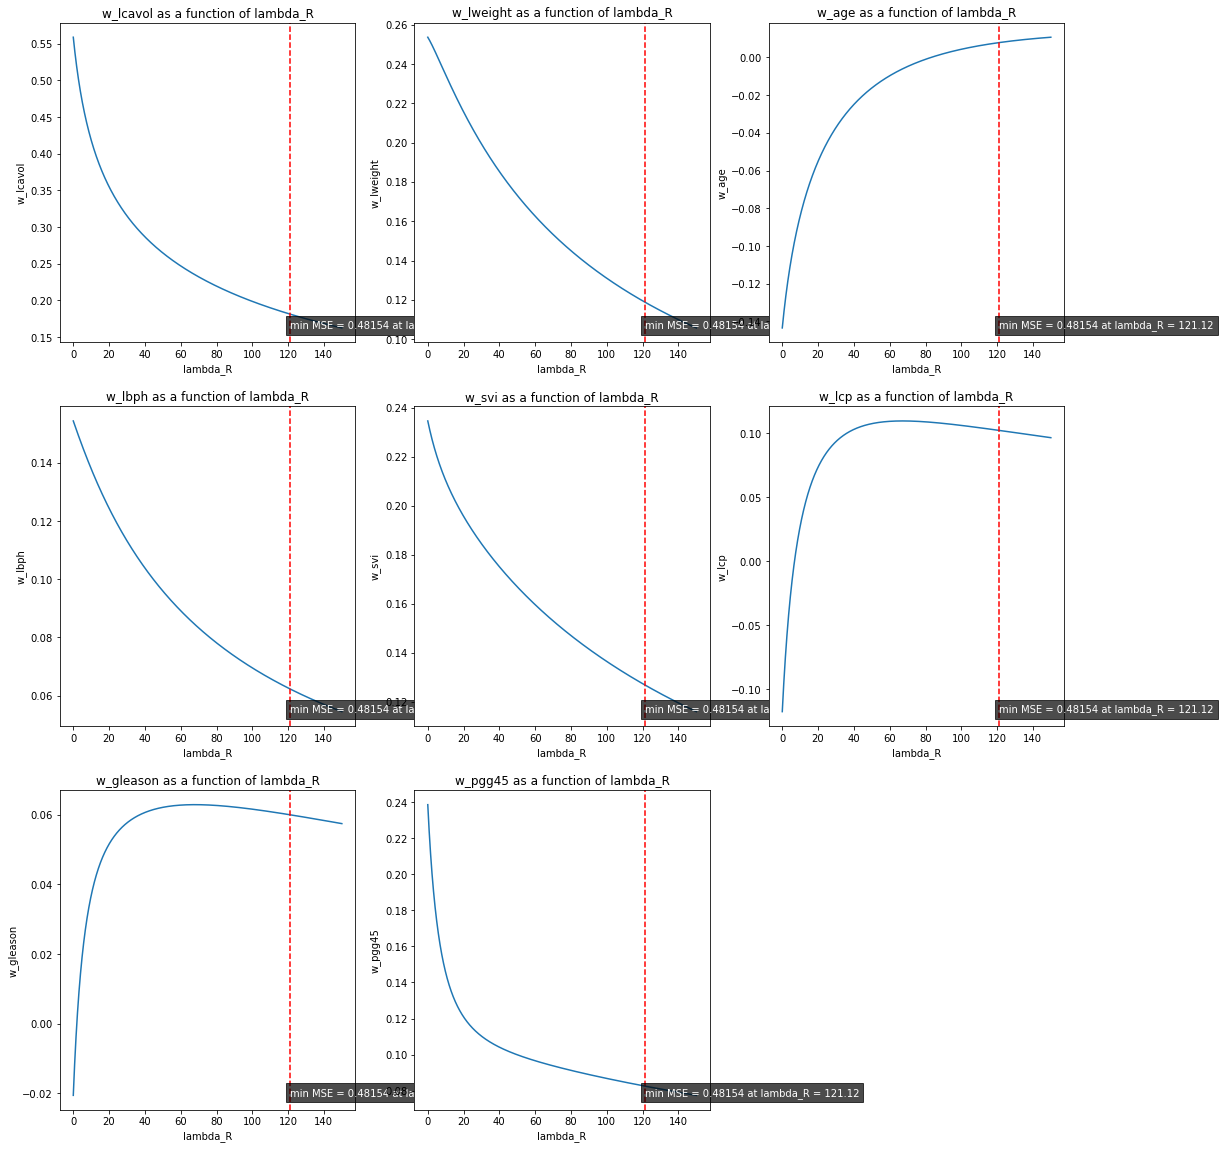

In [46]:
# Diplay a plot of the weights as a function of lambda_R
features = df_train.columns.tolist()[:-1]
n_cols = 3
n_rows = int(np.ceil(len(features) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 20))

for i, ax in enumerate(axes.flatten()):
    if i >= len(features):
        ax.axis("off")
        continue
    ax.plot(results_df["lambda"].values, results_df[f"w_{features[i]}"].values)
    # Add a vertical line at the minimum MSE
    ax.axvline(
        min_mse_lambda,
        color="red",
        linestyle="--",
        label=f"lambda_R = {min_mse_lambda:.2f} for min MSE = {min_mse:.5f}",
    )
    # add text annotation for the minimum MSE with a black background and white text
    ax.text(
        min_mse_lambda,
        results_df[f"w_{features[i]}"].min(),
        f"min MSE = {min_mse:.5f} at lambda_R = {min_mse_lambda:.2f}",
        bbox=dict(facecolor="black", alpha=0.7),
        color="white",
    )

    ax.set_xlabel("lambda_R")
    ax.set_ylabel(f"w_{features[i]}")
    ax.set_title(f"w_{features[i]} as a function of lambda_R")

**Questions:**


**2.1** What $\lambda$ do you get the best performance (i.e., lowest MSE)?

**2.2** Compare the results from part 1, when $\lambda = 0$. Why are the results similar or different?

**2.3** Compare the weights with the weights from part 1? If you were to rank descending by the absolute value of the weights, how different is the ordering with part 1? Is the most important variable in part 1 the same as in part 2? If not, can you provide a reason?



# 3. Linear Regression with L1 Regularization (Lasso)

Unlike Ridge Regression, there is no closed-form solution for Lasso, meaning there is no normal equation we can solve to immediately get all of our ideal model parameters. While it can be solved by minimizing one coordinate a time using a technique called [Coordinate Descent](http://www.adeveloperdiary.com/data-science/machine-learning/introduction-to-coordinate-descent-using-least-squares-regression/), here you can implement your solution using Scikit-Learn Lasso inside a class called `LassoRegression` which also extends `BaseLearningAlgorithm`. Like part 2, iterate through the regression penalty term, $\alpha$ , and plot (a) MSE loss as a function of $\alpha$, and (b) each coefficient weight as a function of $\alpha$.

**Note**: here we swap notation a little, replacing $\lambda$ with $\alpha$ to fit with the Scikit-Learn convention.




In [83]:
class LassoRegression(BaseLearningAlgorithm):
    """A Lasso Regression model implementing eq. 3.52."""

    def __init__(self, alpha: float):
        """Initializes the model."""
        self._model = None
        self.alpha = alpha

    def train(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        """Trains the model."""
        # Add a column of ones to the training data
        # this is to account for the bias term
        # see Hastie p. 45
        X_train = np.c_[X_train, np.ones(X_train.shape[0])]
        # Compute the least squares solution using eq. 3.52
        self._model = Lasso(alpha=self.alpha, fit_intercept=False)
        self._model.fit(X_train, y_train)
        self._weights = self._model.coef_

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Predicts on an unlabeled sample, X."""
        # Add a column of ones to the test data
        X_test = np.c_[X_test, np.ones(X_test.shape[0])]
        # Return the predictions
        return X_test @ self._weights

    @property
    def name(self) -> str:
        """Returns the name of the algorithm."""
        return "Lasso Regression"

In [60]:
# let's try a few values of alpha
alpha_range = np.linspace(0, 1, 10000).tolist()

# Setting up a dataframe where we'll store the results and the weights
metrics_to_track = (
    ["alpha", "mse", "rmse", "r2"]
    + [f"w_{feature}" for feature in df_train.columns if feature != "lpsa"]
    + ["bias"]
)
print(f"Metrics to track: {metrics_to_track}")
lr_results = np.zeros((len(alpha_range), len(metrics_to_track)))

for i, alpha in enumerate(alpha_range):
    print(f">>> Model {i}/{len(alpha_range)}. alpha: {alpha}")

    lasso_regression_model = LassoRegression(alpha=alpha)
    # Train the model on normalized data
    lasso_regression_model.train(X_train_std, y_train_std)
    y_pred_lasso = lasso_regression_model.predict(X_test_std)
    y_pred_lasso = std_scaler.inverse_transform(y=y_pred_lasso)

    lasso_reg_results = regression_report(y_test, y_pred_lasso, plot_results=False)
    lr_test_mse = lasso_reg_results["MSE"][0]
    lr_test_rmse = lasso_reg_results["RMSE"][0]
    lr_test_r2 = lasso_reg_results["R^2"][0]

    weights = lasso_regression_model._weights.tolist()
    # record the results
    lr_results[i] = [alpha, lr_test_mse, lr_test_rmse, lr_test_r2] + weights

Metrics to track: ['alpha', 'mse', 'rmse', 'r2', 'w_lcavol', 'w_lweight', 'w_age', 'w_lbph', 'w_svi', 'w_lcp', 'w_gleason', 'w_pgg45', 'bias']
>>> Model 0/10000. alpha: 0.0
Mean Squared Error: 0.5561806405313202
Root Mean Squared Error: 0.7457751943657822
R^2: 0.2773118726338696
>>> Model 1/10000. alpha: 0.00010001000100010001
Mean Squared Error: 0.5558823028982375
Root Mean Squared Error: 0.7455751490616069
R^2: 0.27769952558268385
>>> Model 2/10000. alpha: 0.00020002000200020003
Mean Squared Error: 0.5555859565105484
Root Mean Squared Error: 0.7453763858015281
R^2: 0.2780845911537655
>>> Model 3/10000. alpha: 0.00030003000300030005
Mean Squared Error: 0.5552914341931563
Root Mean Squared Error: 0.74517879344031
R^2: 0.27846728657052855
>>> Model 4/10000. alpha: 0.00040004000400040005
Mean Squared Error: 0.5549987241529961
Root Mean Squared Error: 0.7449823649946327
R^2: 0.27884762715660605
>>> Model 5/10000. alpha: 0.0005000500050005
Mean Squared Error: 0.5547081139550358
Root Mean S

C:\Users\togru\AppData\Local\Temp\ipykernel_13584\207973507.py:17: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._model.fit(X_train, y_train)
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\togru\anaconda3\envs\my_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.316e+00, tolerance: 6.700e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.

Mean Squared Error: 0.5372079162541085
Root Mean Squared Error: 0.7329446884002287
R^2: 0.30196458720126906
>>> Model 130/10000. alpha: 0.013001300130013002
Mean Squared Error: 0.5371630140387922
Root Mean Squared Error: 0.7329140563795951
R^2: 0.3020229320905673
>>> Model 131/10000. alpha: 0.013101310131013101
Mean Squared Error: 0.5371192414041019
Root Mean Squared Error: 0.7328841937196503
R^2: 0.3020798092291961
>>> Model 132/10000. alpha: 0.013201320132013201
Mean Squared Error: 0.5370765983500374
Root Mean Squared Error: 0.7328551005144451
R^2: 0.3021352186171561
>>> Model 133/10000. alpha: 0.013301330133013302
Mean Squared Error: 0.5370350848765992
Root Mean Squared Error: 0.7328267768556217
R^2: 0.30218916025444653
>>> Model 134/10000. alpha: 0.013401340134013402
Mean Squared Error: 0.5369944710069999
Root Mean Squared Error: 0.7327990659157528
R^2: 0.3022419329675309
>>> Model 135/10000. alpha: 0.013501350135013503
Mean Squared Error: 0.5369546941651662
Root Mean Squared Error

In [62]:
# Let's sort the results by the MSE and R2
lr_results_df = pd.DataFrame(lr_results, columns=metrics_to_track)
lr_results_df.sort_values(
    by=["mse", "r2"], ascending=[True, False], inplace=False
).head(10)

alpha       mse      rmse        r2  w_lcavol  w_lweight  w_age  \
1815  0.181518  0.390297  0.624738  0.492857  0.481664   0.120860    0.0   
1816  0.181618  0.390297  0.624738  0.492857  0.481649   0.120770    0.0   
1814  0.181418  0.390297  0.624738  0.492857  0.481679   0.120950    0.0   
1817  0.181718  0.390297  0.624738  0.492857  0.481634   0.120680    0.0   
1813  0.181318  0.390297  0.624738  0.492857  0.481694   0.121040    0.0   
1818  0.181818  0.390298  0.624738  0.492856  0.481619   0.120590    0.0   
1812  0.181218  0.390298  0.624738  0.492856  0.481709   0.121130    0.0   
1819  0.181918  0.390298  0.624738  0.492856  0.481604   0.120500    0.0   
1811  0.181118  0.390298  0.624738  0.492856  0.481725   0.121221    0.0   
1820  0.182018  0.390298  0.624738  0.492856  0.481588   0.120409    0.0   

      w_lbph     w_svi  w_lcp  w_gleason   w_pgg45  bias  
1815     0.0  0.096842    0.0        0.0  0.021583  -0.0  
1816     0.0  0.096797    0.0        0.0  0.021511  -0.0  
1814     0.0  0.096887    0.0        0.0  0.021655  -0.0  
1817     0.0  0.096753    0.0        0.0  0.021440  -0.0  
1813     0.0  0.096932    0.0        0.0  0.021726  -0.0  
1818     0.0  0.096708    0.0        0.0  0.021368  -0.0  
1812     0.0  0.096977    0.0        0.0  0.021798  -0.0  
1819     0.0  0.096663    0.0        0.0  0.021296  -0.0  
1811     0.0  0.097021    0.0        0.0  0.021870  -0.0  
1820     0.0  0.096618    0.0        0.0  0.021225  -0.0

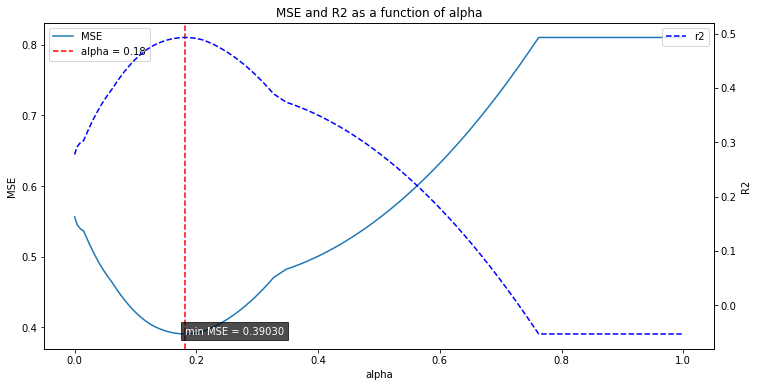

In [73]:
# let's pot the MSE and R2 as a function of alpha
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(lr_results_df["alpha"].values, lr_results_df["mse"].values, label="MSE")

# Add a vertical line at the minimum MSE
min_mse_lr = lr_results_df["mse"].min()
min_mse_alpha = lr_results_df[lr_results_df["mse"] == min_mse_lr]["alpha"].values[0]
ax.axvline(
    min_mse_alpha, color="red", linestyle="--", label=f"alpha = {min_mse_alpha:.2f}"
)
# Add text annotation for the minimum MSE with a black background and white text
ax.text(
    min_mse_alpha,
    min_mse_lr,
    f"min MSE = {min_mse_lr:.5f}",
    bbox=dict(facecolor="black", alpha=0.7),
    color="white",
)

# Create a twin Axes sharing the xaxis for the r2
ax2 = ax.twinx()
ax2.plot(lr_results_df["alpha"].values, lr_results_df["r2"].values, "b--", label="r2")
ax.set_xlabel("alpha")
ax.set_ylabel("MSE")
ax2.set_ylabel("R2")
ax.set_title("MSE and R2 as a function of alpha")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")

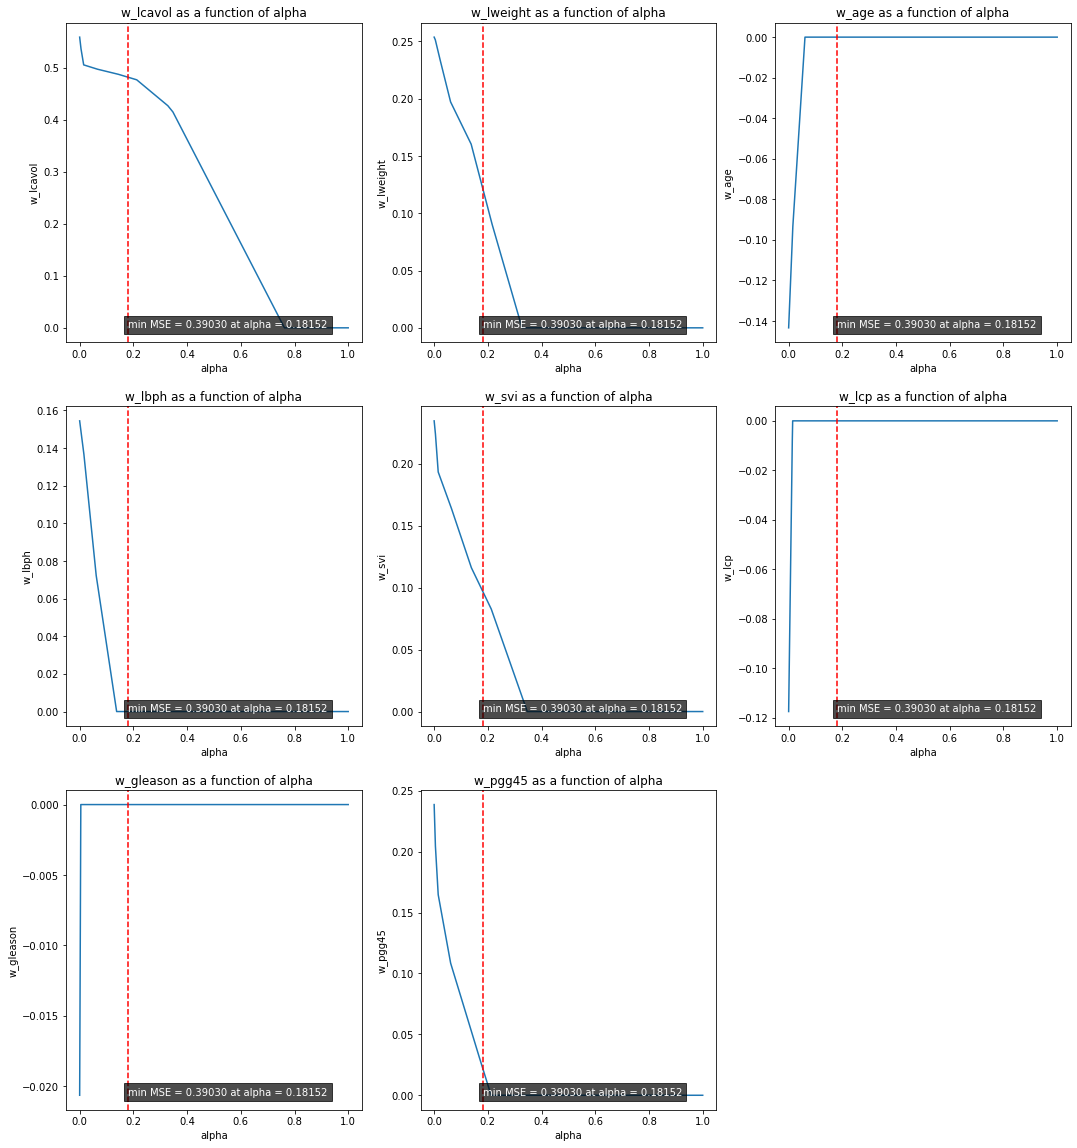

In [74]:
# Diplay a plot of the weights as a function of alpha
features = df_train.columns.tolist()[:-1]
n_cols = 3
n_rows = int(np.ceil(len(features) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 20))

for i, ax in enumerate(axes.flatten()):
    if i >= len(features):
        ax.axis("off")
        continue
    ax.plot(lr_results_df["alpha"].values, lr_results_df[f"w_{features[i]}"].values)
    # add a vertical line at the minimum MSE
    ax.axvline(
        min_mse_alpha,
        color="red",
        linestyle="--",
        label=f"alpha = {min_mse_alpha:.5f} for min MSE = {min_mse_lr:.5f}",
    )
    # add text annotation for the minimum MSE with a black background and white text
    ax.text(
        min_mse_alpha,
        lr_results_df[f"w_{features[i]}"].min(),
        f"min MSE = {min_mse_lr:.5f} at alpha = {min_mse_alpha:.5f}",
        bbox=dict(facecolor="black", alpha=0.7),
        color="white",
    )

    ax.set_xlabel("alpha")
    ax.set_ylabel(f"w_{features[i]}")
    ax.set_title(f"w_{features[i]} as a function of alpha")

**Questions:**

**3.1** Under what conditions would you prefer L2 or L1 regression over vice versa? (Consider the discussion in Hastie 3.6.)

**3.2** Why do some coefficients become zero? Do you think this may be a method of subset selection as described in Hastie 3.3?

**3.3** Which method performs better (i.e., has the lower MSE)?

**3.4** Comparing the relative ranking of the weights at the lowest MSE, do Ridge Regression and Lasso Regression “agree” on the most important weights?

**3.5** In your own words, define **bias** and **variance**. Describe how bias and variance affected the results of parts 1, 2, and 3.


# 4.  Iterative Optimization with Gradient Descent
Implement a class called `RidgeRegressionGradDescent` that extends `BaseLearningAlgorithm` that performs linear regression with L2 regularization using [gradient descent](https://www.deeplearningbook.org/contents/numerical.html), Goodfellow 4.5. Plot both training and test MSE loss result vs. iteration.  Iterate through the regression penalty term, $\lambda$ , and plot (a) MSE loss as a function of $\lambda$, and (b) each coefficient weight as a function of $\lambda$. Use only numpy and matplotlib for your solution.


Here, we'll be using the equation of the gradient of the loss function with respect to the weights. The loss function is the MSE loss function and including the L2 regularization term, it is defined as:

$$ L(\boldsymbol{\beta}) = \frac{1}{n} \sum_{i=1}^{n} (Y_i - \hat{Y}_i)^2 + \lambda \sum_{j=1}^{p} \beta_j^2 $$

In order to find the gradient of the loss function, we need to find the partial derivative of the loss function with respect to the weights. The partial derivative of the loss function with respect to the weights wil be as follows in its matrix form:

$$ \frac{\partial L(\boldsymbol{\beta})}{\partial \boldsymbol{\beta}} = 2 \boldsymbol{X}^T (\boldsymbol{X} \boldsymbol{\beta} - \boldsymbol{Y}) + 2 \lambda \boldsymbol{\beta} $$

In [78]:
class RidgeRegressionGradDescent(BaseLearningAlgorithm):
    """A Ridge Regression model implementing eq. 4.21 and 4.22. from Goodfellow."""
    
    def __init__(self, lambda_R: float, learning_rate: float, max_iter: int, tol: float):
        """Initializes the model."""
        self._model = None
        self.lambda_R = lambda_R
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
    
    def train(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        """Trains the model."""
        # Add a column of ones to the training data
        # this is to account for the bias term
        # see Hastie p. 45
        X_train = np.c_[X_train, np.ones(X_train.shape[0])]
        # Compute the least squares solution using eq. 3.44
        self._weights = np.random.randn(X_train.shape[1])
        
        for i in range(self.max_iter):
            # Compute the predictions
            y_pred = X_train @ self._weights            
            # Compute the residuals
            residuals = y_pred - y_train           
            
            # Terminate if the loss or the predictions contain NaNs
            if np.isnan(residuals).any() or np.isnan(y_pred).any():
                print(f"NaNs encountered at iteration {i}.")
                break
             
            # Compute the gradient without regularizing the bias term
            grad = 2 * X_train.T @ residuals
            # Regularize the weights except for the bias term
            grad[:-1] += 2 * self.lambda_R * self._weights[:-1]
            # Update the weights
            self._weights = self._weights - self.learning_rate * grad
            
            if np.linalg.norm(grad) < self.tol:
                print(f"Converged after {i} iterations.")
                break
    
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Predicts on an unlabeled sample, X."""
        # Add a column of ones to the test data
        X_test = np.c_[X_test, np.ones(X_test.shape[0])]
        # Return the predictions
        return X_test @ self._weights
        
    @property
    def name(self) -> str:
        """Returns the name of the algorithm."""
        return "Ridge Regression Gradient Descent"

Let's test this implementation by comparing the results of RidgeRegressionGradDescent when $\lambda = 0$ with the results of BasicLeastSquaresRegression. They should be the same. For this case we will test based on a fixed number of iterations and a fixed learning rate.

In [77]:
# Let's try Lambda_R = 0.1, learning_rate = 0.01, max_iter = 10000, tol = 1e-8
lambda_R = 0.1
learning_rate = 0.001
max_iter = 10000
tol = 1e-12

std_scaler = StandardScaler()
std_scaler.fit(X_train, y_train)
X_train_std, y_train_std = std_scaler.transform(X_train, y_train)
X_test_std = std_scaler.transform(X_test)

ridge_regression_grad_descent_model = RidgeRegressionGradDescent(
    lambda_R=lambda_R, learning_rate=learning_rate, max_iter=max_iter, tol=tol
)
ridge_regression_grad_descent_model.train(X_train_std, y_train_std)
y_pred_ridge_grad_descent = ridge_regression_grad_descent_model.predict(X_test_std)
y_pred_ridge_grad_descent = std_scaler.inverse_transform(y=y_pred_ridge_grad_descent)
print(y_pred_ridge_grad_descent)
reg_res_ridge_grad_descent = regression_report(y_test, y_pred_ridge_grad_descent)

TypeError: Can't instantiate abstract class RidgeRegressionGradDescent with abstract method initialize_with_params

While keeping the same number of iterations and learning rate, let's see what happens when we vary the penalty term, lambda in the range of 0 to 10

In [70]:
learning_rate = 0.001
max_iter = 10000
tol = 1e-12

# Let's set a range of values for lambda_R
lambda_R_range = np.linspace(0, 150, 10000).tolist()

# Setting up a dataframe where we'll store the results and the weights
metrics_to_track = ['lambda', 'mse', 'rmse', 'r2'] + [f'w_{feature}' for feature in df_train.columns if feature != 'lpsa'] + ['bias']
print(f"Metrics to track: {metrics_to_track}")
rr_grad_desc_results = np.zeros((len(lambda_R_range), len(metrics_to_track)))

for i, lambda_R in enumerate(lambda_R_range):
    print(f">>> Model {i}/{len(lambda_R_range)}. Lambda_R: {lambda_R}")
    
    ridge_regression_grad_descent_model = RidgeRegressionGradDescent(lambda_R=lambda_R, learning_rate=learning_rate, max_iter=max_iter, tol=tol)
    ridge_regression_grad_descent_model.train(X_train_std, y_train_std)
    y_pred_ridge_grad_descent = ridge_regression_grad_descent_model.predict(X_test_std)
    y_pred_ridge_grad_descent = std_scaler.inverse_transform(y=y_pred_ridge_grad_descent)
    
    ridge_reg_results = regression_report(y_test, y_pred_ridge_grad_descent, plot_results=False)
    rr_test_mse = ridge_reg_results['MSE'][0]
    rr_test_rmse = ridge_reg_results['RMSE'][0]
    rr_test_r2 = ridge_reg_results['R^2'][0]
    
    weights = ridge_regression_grad_descent_model._weights.tolist()
    # record the results   
    rr_grad_desc_results[i] = [lambda_R, rr_test_mse, rr_test_rmse, rr_test_r2] + weights

Metrics to track: ['lambda', 'mse', 'rmse', 'r2', 'w_lcavol', 'w_lweight', 'w_age', 'w_lbph', 'w_svi', 'w_lcp', 'w_gleason', 'w_pgg45', 'bias']
>>> Model 0/10000. Lambda_R: 0.0


NameError: name 'RidgeRegressionGradDescent' is not defined

In [115]:
rr_grad_desc_results_df = pd.DataFrame(rr_grad_desc_results, columns=metrics_to_track)
rr_grad_desc_results_df.sort_values(by=['mse', 'r2'], ascending=[True, False], inplace=False).head(10)

lambda       mse      rmse        r2  w_lcavol  w_lweight     w_age  \
403  121.021021  0.481537  0.693929  0.374302  0.181335   0.119022  0.007784   
404  121.321321  0.481537  0.693929  0.374302  0.181114   0.118867  0.007824   
402  120.720721  0.481538  0.693929  0.374301  0.181558   0.119177  0.007745   
405  121.621622  0.481538  0.693929  0.374301  0.180893   0.118712  0.007863   
401  120.420420  0.481539  0.693930  0.374300  0.181781   0.119333  0.007704   
406  121.921922  0.481539  0.693930  0.374299  0.180672   0.118558  0.007902   
400  120.120120  0.481540  0.693931  0.374298  0.182004   0.119489  0.007664   
407  122.222222  0.481541  0.693931  0.374297  0.180452   0.118405  0.007941   
399  119.819820  0.481542  0.693932  0.374296  0.182228   0.119646  0.007624   
408  122.522523  0.481543  0.693933  0.374295  0.180233   0.118251  0.007979   

       w_lbph     w_svi     w_lcp  w_gleason   w_pgg45          bias  
403  0.062315  0.127022  0.102310   0.060033  0.082591 -6.194841e-15  
404  0.062223  0.126897  0.102252   0.060008  0.082534  6.059031e-15  
402  0.062408  0.127148  0.102368   0.060058  0.082648 -6.143330e-15  
405  0.062131  0.126772  0.102193   0.059983  0.082477  6.114514e-15  
401  0.062501  0.127273  0.102426   0.060083  0.082705  5.710074e-15  
406  0.062039  0.126648  0.102135   0.059958  0.082420  6.231822e-15  
400  0.062594  0.127399  0.102485   0.060108  0.082762  6.275232e-15  
407  0.061947  0.126524  0.102076   0.059933  0.082363 -6.384164e-15  
399  0.062687  0.127525  0.102543   0.060132  0.082819  6.057348e-15  
408  0.061856  0.126399  0.102018   0.059907  0.082306 -5.924040e-15

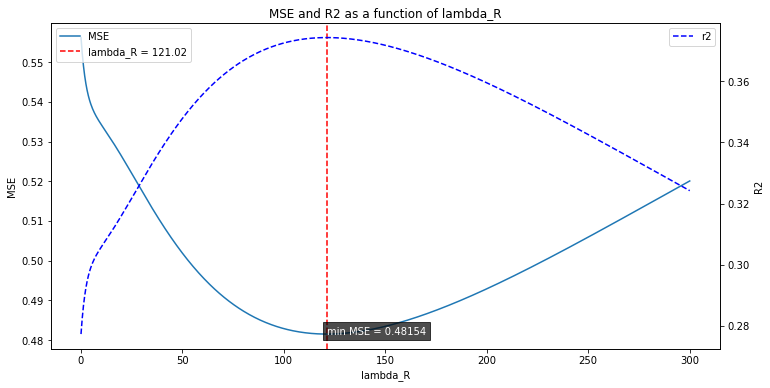

In [116]:
# let's pot the MSE and R2 as a function of lambda_R
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(rr_grad_desc_results_df['lambda'].values, rr_grad_desc_results_df['mse'].values, label='MSE')

# Add a vertical line at the minimum MSE
min_mse = rr_grad_desc_results_df['mse'].min()
min_mse_lambda = rr_grad_desc_results_df[rr_grad_desc_results_df['mse'] == min_mse]['lambda'].values[0]
ax.axvline(min_mse_lambda, color='red', linestyle='--', label=f'lambda_R = {min_mse_lambda:.2f}')
# Add text annotation for the minimum MSE with a black background and white text
ax.text(min_mse_lambda, min_mse, f"min MSE = {min_mse:.5f}", 
        bbox=dict(facecolor='black', alpha=0.7), color='white')

# Create a twin Axes sharing the xaxis for the r2
ax2 = ax.twinx()
ax2.plot(rr_grad_desc_results_df['lambda'].values, rr_grad_desc_results_df['r2'].values, 'b--', label='r2')
ax.set_xlabel('lambda_R')
ax.set_ylabel('MSE')
ax2.set_ylabel('R2')
ax.set_title('MSE and R2 as a function of lambda_R')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')


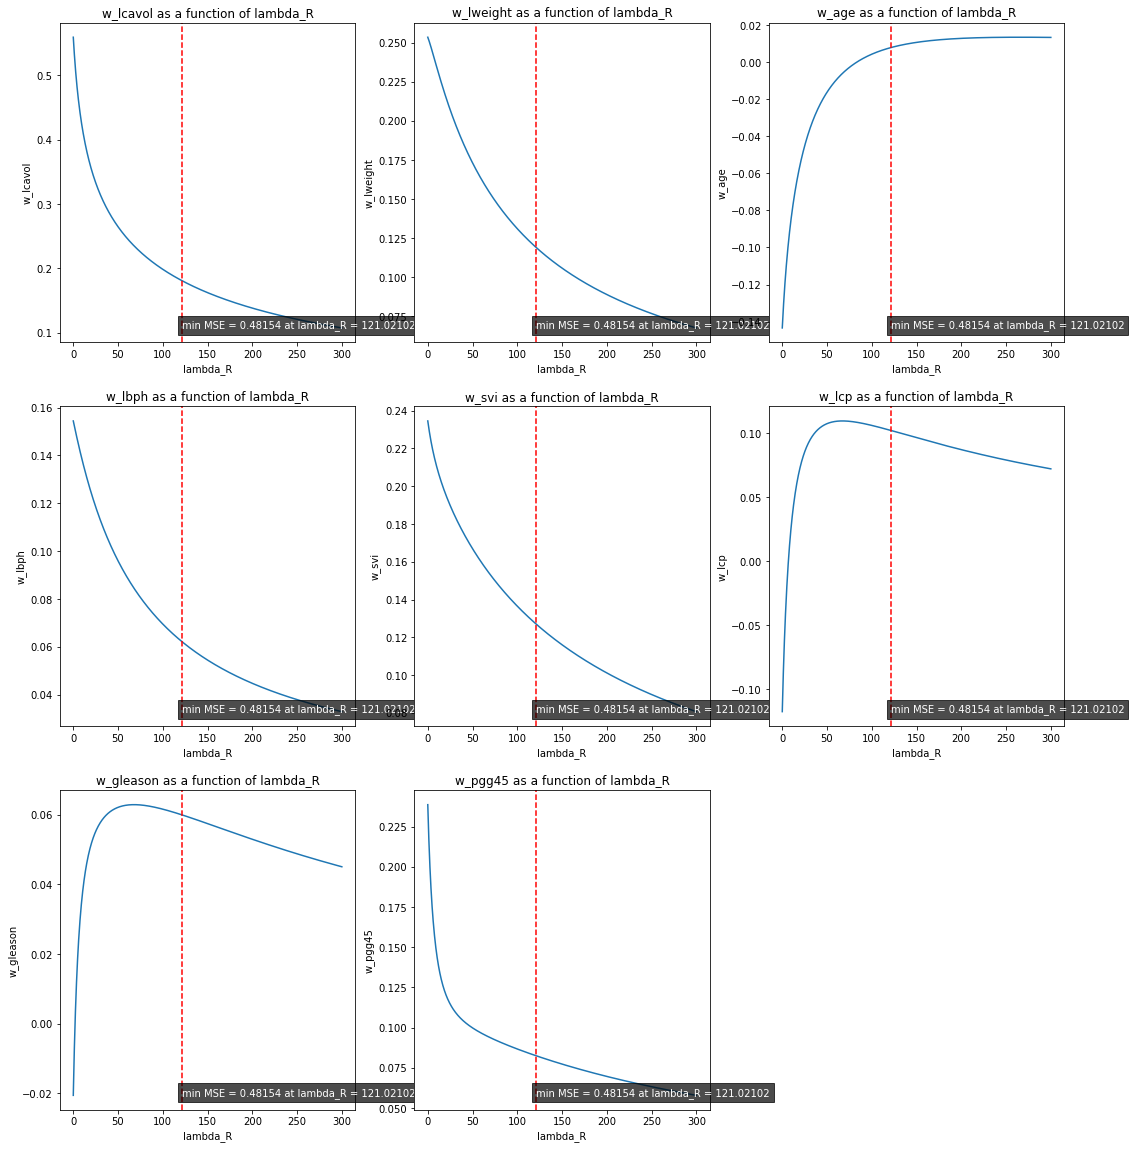

In [117]:
# Diplay a plot of the weights as a function of lambda_R
features = df_train.columns.tolist()[:-1]
n_cols = 3
n_rows = int(np.ceil(len(features) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 20))

for i, ax in enumerate(axes.flatten()):
    if i >= len(features):
        ax.axis('off')
        continue
    ax.plot(rr_grad_desc_results_df['lambda'].values, rr_grad_desc_results_df[f'w_{features[i]}'].values)
    # add a vertical line at the minimum MSE
    ax.axvline(min_mse_lambda, color='red', linestyle='--', label=f'lambda_R = {min_mse_lambda:.5f} for min MSE = {min_mse:.5f}')
    # add text annotation for the minimum MSE with a black background and white text
    ax.text(min_mse_lambda, rr_grad_desc_results_df[f'w_{features[i]}'].min(), f"min MSE = {min_mse:.5f} at lambda_R = {min_mse_lambda:.5f}", 
            bbox=dict(facecolor='black', alpha=0.7), color='white')
    
    
    ax.set_xlabel('lambda_R')
    ax.set_ylabel(f'w_{features[i]}')
    ax.set_title(f'w_{features[i]} as a function of lambda_R')

**Questions:**

**4.1** How many iterations are required to converge, and are there any performance differences compared to part 2?

**4.2** Derive the gradient of L2 regularization loss. Encode your answer as [$\LaTeX$ equations](https://colab.research.google.com/github/bebi103a/bebi103a.github.io/blob/master/lessons/00/intro_to_latex.ipynb), and justify every step, please.

**4.3** Do you converge on the same minimum loss value? How do the coefficients compare to part 1?


#5. [OPTIONAL] Iterative Optimization using Coordinate Descent

**Worth up to 2% of the semester grade.**

Review Hastie 3.8.6 and this [presentation](https://www.cs.cmu.edu/~pradeepr/convexopt/Lecture_Slides/coordinate_descent.pdf) on coordinate descent. Using just numpy reimplement part 3 with coordinate descent. Like part 3, iterate through the regression penalty term, $\lambda$, and plot (a) MSE loss as a function of $\lambda$, and (b) each coefficient weight as a function of $\lambda$. Use only numpy and matplotlib for your solution.



**Questions:**

**5.1** How does your implementation compare with Scikit-Learn’s implementation in terms of minimum MSE loss and coefficients?

**5.2** Is the optimization surface convex or non-convex?

**5.3** What makes the optimization surface *non-smooth* and how is coordinate descent able to overcome this problem?
